In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

print dtype

<type 'torch.cuda.FloatTensor'>


In [4]:
imsize = 200  # desired size of the output image

loader = transforms.Compose([
    transforms.Scale(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor
preprocess = loader

def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(preprocess(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image


style = image_loader("../../data/picasso.jpg").type(dtype)
content = image_loader("../../data/dancing.jpg").type(dtype)



In [5]:
unloader = transforms.ToPILImage()  # reconvert into PIL image


def imshow(tensor):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)


fig = plt.figure(0)

plt.subplot(221)
imshow(style.data)
plt.subplot(222)
imshow(content.data)

In [6]:
class ContentLoss(nn.Module):
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion.forward(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_graph=retain_variables)
        return self.loss

In [7]:
class GramMatrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

In [8]:
class StyleLoss(nn.Module):
    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram.forward(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion.forward(self.G, self.target)
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_graph=retain_variables)
        return self.loss

In [9]:
cnn = models.vgg16(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

In [11]:
print isinstance([], list)

True


In [12]:
# desired depth layers to compute style/content losses :
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# just in order to have an iterable access to or list of content/syle losses
content_losses = []
style_losses = []

model = nn.Sequential()  # the new Sequential module network
gram = GramMatrix()  # we need a gram module in order to compute style targets

# move these modules to the GPU if possible:
if use_cuda:
    model = model.cuda()
    gram = gram.cuda()

# weigth associated with content and style losses
content_weight = 1
style_weight = 1000

i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model.forward(content).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model.forward(style).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model.forward(content).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model.forward(style).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

        i += 1

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(i)
        model.add_module(name, layer)  # ***

In [13]:
model

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (relu_1): ReLU(inplace)
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (relu_2): ReLU(inplace)
  (pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (relu_3): ReLU(inplace)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss(
    (criterion): MSELoss()
  )
  (style_loss_4): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (relu_4): ReLU(inplace)
  (pool_5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

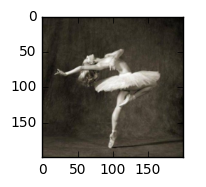

In [25]:
input = image_loader("../../data/dancing.jpg").type(dtype)
# if we want to fill it with a white noise:
# input.data = torch.randn(input.data.size()).type(dtype)

# add the original input image to the figure:
plt.subplot(223)
imshow(input.data)
plt.show()

In [26]:
# this line to show that input is a parameter that requires a gradient
input = nn.Parameter(input.data)
optimizer = optim.LBFGS([input])

run [10]:
tensor(7.1852, device='cuda:0')
tensor(0.6911, device='cuda:0')


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


run [20]:
tensor(3.2239, device='cuda:0')
tensor(0.8698, device='cuda:0')
run [30]:
tensor(2.4492, device='cuda:0')
tensor(0.9249, device='cuda:0')
run [40]:
tensor(1.5708, device='cuda:0')
tensor(0.9120, device='cuda:0')
run [50]:
tensor(1.1292, device='cuda:0')
tensor(0.9089, device='cuda:0')
run [60]:
tensor(0.8845, device='cuda:0')
tensor(0.9537, device='cuda:0')
run [70]:
tensor(0.4441, device='cuda:0')
tensor(0.9151, device='cuda:0')
run [80]:
tensor(0.2823, device='cuda:0')
tensor(0.8598, device='cuda:0')
run [90]:
tensor(0.2279, device='cuda:0')
tensor(0.8155, device='cuda:0')
run [100]:
tensor(0.1970, device='cuda:0')
tensor(0.7866, device='cuda:0')
run [110]:
tensor(0.1880, device='cuda:0')
tensor(0.7534, device='cuda:0')
run [120]:
tensor(0.1767, device='cuda:0')
tensor(0.7373, device='cuda:0')
run [130]:
tensor(0.1710, device='cuda:0')
tensor(0.7240, device='cuda:0')
run [140]:
tensor(0.1643, device='cuda:0')
tensor(0.7146, device='cuda:0')
run [150]:
tensor(0.1562, device=

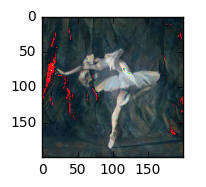

In [27]:
run = [0]
while run[0] <= 300:
    
    def closure():
        optimizer.zero_grad()
        model.forward(input)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.backward()
        for cl in content_losses:
            content_score += cl.backward()

        run[0]+=1
        if run[0] % 10 == 0:
            print("run " + str(run) + ":")
            print(style_score.data[0])
            print(content_score.data[0])

        return content_score+style_score

    optimizer.step(closure)

plt.subplot(224)
imshow(input.data)
plt.show()